In [14]:
import time
import pandas as pd
import numpy as np
import bottleneck as bn
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf

class BackTrader():
    def __init__(self,start=[2022,1,30],end=[2022,12,30],oraccount=10000,spreads=0.02,Hold_time_set=[False,7],Profit_set=[False,0.20,0.20]):
        # 回测时间段
        self.start_time=datetime.date(start[0],start[1],start[2])
        self.end_time=datetime.date(end[0],end[1],end[2])

        # 本金
        self.ora=oraccount

        self.spreads=spreads  # 滑动比率

        # 持股天数机制
        self.Hold_Time_set=Hold_time_set

        # 利润止盈止损机制
        self.Profit_set=Profit_set

    def Load_Data(self,path='E:/Quant_stock_data/Stock_day_data/HSAday.pkl',single_stock=[False,'']):
        self.path=path
        hsa=pd.read_pickle(path)
        hsa=hsa.set_index('Date')
        hsa=hsa.groupby('Code').apply(lambda x: x[self.start_time:self.end_time])
        hsa=hsa.reset_index(level='Date')
        hsa=hsa.reset_index(drop=True)
        self.hsa=hsa
        self.single_stock=single_stock
        if single_stock[0]:
            self.hsa=self.hsa.loc[self.hsa['Code']==single_stock[1]]
        return self.hsa
    
    def Strategic_BOLL(self,maPeriod=20,stdPeriod=20,stdRange=2):
        # 计算BOLL值
        # maPeriod BOLL布林线中轨的参数
        # stdPeriod BOLL布林线标准差的参数
        # stdRange BOLL上下轨和中轨距离的参数

        # 计算布林线上下轨
        self.hsa['Bollup']=self.hsa.groupby('Code')['Close_adjusted'].transform(lambda x: rollmean_bottlneck(x,maPeriod))+stdRange*self.hsa.groupby('Code')['Close_adjusted'].transform(lambda x: rollstd_bottlneck(x,stdPeriod))
        self.hsa['Bolllow']=self.hsa.groupby('Code')['Close_adjusted'].transform(lambda x: rollmean_bottlneck(x,maPeriod))-stdRange*self.hsa.groupby('Code')['Close_adjusted'].transform(lambda x: rollstd_bottlneck(x,stdPeriod))

        # Strategic Part
        # 买卖信号：收盘价低于布林下限  收盘价高于布林上限
        self.hsa['Buy_Sign']=(self.hsa['Bolllow']>self.hsa['Close_adjusted'])
        self.hsa['Sell_Sign']=(self.hsa['Bollup']<self.hsa['Close_adjusted'])

        # Buy and Sell Sign
        self.hsa['Buy_Sign']=self.hsa['Buy_Sign'].apply(lambda x: 1 if x else 0)
        self.hsa['Sell_Sign']=self.hsa['Sell_Sign'].apply(lambda x: -1 if x else 0)

        # 合成Sign
        self.hsa['Pre_Sign']=self.hsa['Buy_Sign']+self.hsa['Sell_Sign']
        
        return self.hsa
    
    def Strategic_MACD(self,alpha1=12,alpha2=26,alpha3=9,beta=16):
        # 使用后复权数据计算：MACD指标
        self.hsa['DIFF']=self.hsa.groupby('Code')['Close_adjusted'].transform(lambda x: x.ewm(span=alpha1,adjust=False).mean())-self.hsa.groupby('Code')['Close_adjusted'].transform(lambda x: x.ewm(span=alpha2,adjust=False).mean())*10
        self.hsa['DEA']=self.hsa.groupby('Code')['DIFF'].transform(lambda x: x.ewm(span=alpha3,adjust=False).mean())
        self.hsa['MACD']=-beta*(self.hsa['DIFF']-self.hsa['DEA'])

        # Strategic_MACD
        # 1. 买入信号：转正  卖出信号：转负
        # 2. 买入信号：谷底  卖出信号：峰值
        # 3. 买入信号：转正  卖出信号：峰值
        # 注意：此处购买价格是按隔天的开盘价进行购买
        def MACD_Sign(x):
            x1=x.to_list()
            x2=[0 for j in range(len(x1))]
            for i in range(2,len(x1),1):
                # 信号1
                if x1[i-1]<0 and x1[i]>0:
                    x2[i]=1
                elif x1[i-1]>0 and x1[i]<0:
                    x2[i]=-1
            return x2
        self.hsa['Pre_Sign']=self.hsa.groupby('Code')['MACD'].transform(MACD_Sign)
        
        return self.hsa
    
    def Trade(self):
        # 下一期开盘才能购买——故signal滞后一期
        self.hsa['Sign']=self.hsa.groupby('Code')['Pre_Sign'].apply(lambda x: x.shift(1))
        self.hsa=self.hsa.fillna(0)

        # 用复权后的数据计算指标值，用不复权的数据计算持仓价值，然后转换到复权后的数据(手数允许带小数)上进行交易.

        # 历史股票交易情况表
        if self.path[-7:-4]=='SBF':
            Stock_table=self.hsa.copy()[['Code','Name','Date','Open','Close','Open_adjusted','Close_adjusted','High_adjusted','Low_adjusted','Pre_Sign','Sign','Delisting']]
        else:
            Stock_table=self.hsa.copy()[['Code','Name','Date','Open','Close','Open_adjusted','Close_adjusted','High_adjusted','Low_adjusted','Pre_Sign','Sign']]
            
        self.Date=Stock_table.Date.unique() # Date--索引
        self.Date.sort()
        Stock_table=Stock_table.set_index(['Date'])
        Stock_table['Hold']=0
        Stock_table['Hold_adjusted']=0
        Stock_table['Cost']=0
        Stock_table['Present price']=Stock_table['Close_adjusted']  # 后复权数据
        Stock_table['Return rate']=0
        Stock_table['Profit']=0
        Stock_table['Buy Account']=0
        Stock_table['Sell Account']=0


        # **********最后一天全部卖掉*******
        # Stock_table['Sign']=Stock_table['Sign'].mask((Stock_table.index==self.Date[-1]),-1)
        if self.path[-7:-4]=='SBF':
            def SBF_sell(x):
                if x.index[-1]<=self.Date[-1]:
                    x.iloc[-1]=-1
                return x
            Stock_table.loc[Stock_table['Delisting']==1,'Sign']=Stock_table.loc[Stock_table['Delisting']==1,].groupby('Code')[['Sign']].apply(SBF_sell)
        
        # 将买和卖间元素进行标记
        Stock_table['Sign']=Stock_table.groupby('Code')['Sign'].transform(Mark_Sign)

        # 用于画图的买卖信号生成：
        def Point_sign(x):
            x2=x.to_list()
            for i in range(1,len(x2),1):
                if x[i-1]==x[i]:
                    x2[i]=0
            return x2
        Stock_table['buysell_sign']=Stock_table.groupby('Code')['Sign'].transform(Point_sign)

        # 买入股票均持股1手
        Stock_table['Hold']=Stock_table['Hold'].mask(Stock_table['Sign']==1,100)

        # 买入股票计算成本价
        Stock_table['Sign_1']=Stock_table.groupby('Code')['Sign'].apply(lambda x: x.shift(1))
        Stock_table=Stock_table.fillna(0)
        Stock_table['Hold_adjusted']=Stock_table['Hold_adjusted'].mask((Stock_table['Sign']==1)&(Stock_table['Sign_1']!=1),(Stock_table['Open']*100+Stock_table['Open'].apply(buycost)+Stock_table['Open'].apply(sellcost))/Stock_table['Open_adjusted'])
        Stock_table['Hold_adjusted']=Stock_table['Hold_adjusted'].mask((Stock_table['Sign']==1)&(Stock_table['Sign_1']==1),1)
        Stock_table['Hold_adjusted']=Stock_table['Hold_adjusted'].mask((Stock_table['Sign']==-1)&(Stock_table['Sign_1']==1),1)
        # 将买和卖间持股标记上
        Stock_table['Hold_adjusted']=Stock_table.groupby('Code')['Hold_adjusted'].transform(Mark)

        Stock_table['Cost']=Stock_table['Cost'].mask((Stock_table['Sign']==1)&(Stock_table['Sign_1']!=1),Stock_table['Open_adjusted'])
        Stock_table['Cost']=Stock_table['Cost'].mask((Stock_table['Sign']==1)&(Stock_table['Sign_1']==1),1)
        Stock_table['Cost']=Stock_table['Cost'].mask((Stock_table['Sign']==-1)&(Stock_table['Sign_1']==1),1)
        # 将买和卖间成本标记上
        Stock_table['Cost']=Stock_table.groupby('Code')['Cost'].transform(Mark)

        # Return rate of each time and each stock
        Stock_table.loc[Stock_table['Cost']!=0,'Return rate']=(Stock_table.loc[Stock_table['Cost']!=0,'Present price']-Stock_table.loc[Stock_table['Cost']!=0,'Cost'])/Stock_table.loc[Stock_table['Cost']!=0,'Cost']

        # Profit of each sell
        Stock_table['Profit']=Stock_table['Profit'].mask(Stock_table['Sign']==-1,(Stock_table['Open_adjusted']-Stock_table['Cost'])*Stock_table['Hold_adjusted'])

        # Buy Amount + Buy cost + Sell cost
        Stock_table['Buy Account']=Stock_table['Buy Account'].mask((Stock_table['Sign']==1)&(Stock_table['Sign_1']!=1),Stock_table['Cost']*Stock_table['Hold_adjusted'])

        # Sell Amount 
        Stock_table['Sell Account']=Stock_table['Sell Account'].mask(Stock_table['Sign']==-1,Stock_table['Open_adjusted']*Stock_table['Hold_adjusted'])

        # 卖出当天不再持有
        Stock_table['Hold_adjusted']=Stock_table['Hold_adjusted'].mask(Stock_table['Sign']==-1,0)
        self.Stock_table=Stock_table

        return self.Stock_table

    def TC(self):
        ######################### TC ########################
        # 构建历史资金变动表
        Fund_table=pd.DataFrame({'Date':self.Date})
        Fund_table['Account']=self.ora  # 权益
        Fund_table['Liquidity']=self.ora  # 流动资金
        Fund_table['Profit']=0  # 盈亏
        Fund_table['Return rate']=0  # 收益率
        Fund_table['NV']=1  # 净值
        Fund_table['Buy Account']=0  # 买入花费
        Fund_table['Sell Account']=0  # 卖出总额
        Fund_table=Fund_table.set_index('Date')
        # Profit
        Fund_table['Profit']=self.Stock_table.groupby('Date')['Profit'].apply(sum)

        # Buy and Sell Account
        Fund_table['Buy Account']=self.Stock_table.groupby('Date')['Buy Account'].apply(sum)
        Fund_table['Sell Account']=self.Stock_table.groupby('Date')['Sell Account'].apply(sum)

        # Liquidity
        Fund_table['Liquidity']=Fund_table['Liquidity']-Fund_table['Buy Account'].cumsum()+Fund_table['Sell Account'].cumsum()

        # Account
        Fund_table['Account']=Fund_table['Liquidity']+self.Stock_table.groupby('Date').apply(lambda x: (x['Hold_adjusted']*x['Present price']).sum())

        # Return rate
        Fund_table['Return rate']=(Fund_table['Account']-self.ora)/self.ora

        # Net value
        Fund_table['NV']=Fund_table['Account']/self.ora

        self.Fund_table=Fund_table

        return self.Fund_table

    def Table(self):
        ########################### Table #################################
        # 交易次数
        NT=int(self.Stock_table.loc[self.Stock_table['Profit']!=0].shape[0])
        # 胜率
        WR=self.Stock_table.loc[self.Stock_table['Profit']>0].shape[0]/NT
        # 盈亏比
        PLR=-self.Stock_table.loc[self.Stock_table['Profit']>0,'Profit'].mean()/self.Stock_table.loc[self.Stock_table['Profit']<0,'Profit'].mean()
        # 实战率
        FR=(WR+PLR)/2
        # 250天交易日，3%的无风险收益率
        rf=0.03
        day=250
        # 年化收益率
        IRR=pow(self.Fund_table.loc[self.Date[-1],'NV'],250/len(self.Date))-1
        # 夏普比率
        exceedRR=(self.Fund_table['Account']-self.Fund_table['Account'].shift(1))/self.Fund_table['Account'].shift(1)-rf/day
        SR=np.sqrt(day)*exceedRR.mean()/exceedRR.std()
        # 最大回撤
        MD=((self.Fund_table['NV'].cummax()-self.Fund_table['NV'])/self.Fund_table['NV'].cummax()).max()

        # 策略技术性指标
        report=pd.DataFrame(np.zeros((6,1),dtype=float),index=['交易次数','胜率','盈亏比','实战率','夏普比率','最大回撤'],columns=['技术性指标'])
        report.loc['交易次数']=NT
        report.loc['胜率']=WR
        report.loc['盈亏比']=PLR
        report.loc['实战率']=FR
        report.loc['年化收益率']=IRR
        report.loc['夏普比率']=SR
        report.loc['最大回撤']=MD
        pd.set_option('display.float_format',  '{:,.3f}'.format) # 显示小数点后三位
        report=report.T
        format_dict = {'交易次数': '{0:.0f}', 
                        '胜率': '{0:.2%}',
                        '盈亏比':'{0:.3f}',
                        '实战率':'{0:.2%}',
                        '年化收益率':'{0:.2%}',
                        '夏普比率':'{0:.3f}',
                        '最大回撤':'{0:.2%}',
                        }
        return report.style.format(format_dict)


    def TC_Graph(self):
        plt.figure(figsize=(15,70))
        plt.subplot(7,1,1)
        plt.plot(self.Fund_table['Account'],'-b')
        plt.title('Account')
        plt.subplot(7,1,2)
        plt.plot(self.Fund_table['Liquidity'],'-b')
        plt.title('Liquidity')
        ax1=plt.subplot(7,1,3)
        self.Fund_table['Profit'].plot(kind="bar",ax=ax1)
        ax1.set_xticklabels([x.strftime("%Y-%m-%d") for x in self.Fund_table.index], rotation=30)
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(int(len(self.Date)/20)))
        plt.title('Profit')
        plt.subplot(7,1,4)
        plt.plot(self.Fund_table['Return rate'],'-b')
        plt.title('Return rate')
        plt.subplot(7,1,5)
        plt.plot(self.Fund_table['NV'],'-b')
        plt.title('Net Value')
        ax2=plt.subplot(7,1,6)
        self.Fund_table['Buy Account'].plot(kind="bar",ax=ax2)
        ax2.set_xticklabels([x.strftime("%Y-%m-%d") for x in self.Fund_table.index], rotation=30)
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(int(len(self.Date)/20)))
        plt.title('Buy Account')
        ax3=plt.subplot(7,1,7)
        self.Fund_table['Sell Account'].plot(kind="bar",ax=ax3)
        ax3.set_xticklabels([x.strftime("%Y-%m-%d") for x in self.Fund_table.index], rotation=30)
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(int(len(self.Date)/20)))
        plt.title('Sell Account')

    def Single_Fig(self,MACD_curve=False):
        if self.single_stock[0]:
            stock=self.Stock_table.loc[self.Stock_table['Code']==self.single_stock[1],['Close_adjusted','Open_adjusted','Low_adjusted','High_adjusted','buysell_sign']]
            stock.columns=['Close','Open','Low','High','Sign']
            buy_sign=stock[['Open','Sign']].copy()
            buy_sign.loc[buy_sign['Sign']!=1,'Open']=None
            sell_sign=stock[['Open','Sign']].copy()
            sell_sign.loc[sell_sign['Sign']!=-1,'Open']=None
            buy_sign=buy_sign['Open']
            sell_sign=sell_sign['Open']

            # 设置mplfinance的蜡烛颜色，up为阳线颜色，down为阴线颜色
            my_color = mpf.make_marketcolors(up='r',
                                            down='g',
                                            edge='inherit',
                                            wick='inherit',
                                            volume='inherit')
            # 设置图表的背景色
            my_style = mpf.make_mpf_style(marketcolors=my_color,
                                        figcolor='(0.82, 0.83, 0.85)',
                                        gridcolor='(0.82, 0.83, 0.85)')
            add_plot=[]

            # 绘制MACD
            self.MACD=self.hsa['MACD']
            self.histogram_positive1=16*(self.hsa['DIFF']-self.hsa['DEA'])
            self.histogram_positive1[~((-self.MACD<0) & (-self.MACD<-self.MACD.shift(1)))]=0
            self.histogram_positive1=-self.histogram_positive1

            self.histogram_positive2=16*(self.hsa['DIFF']-self.hsa['DEA'])
            self.histogram_positive2[~((-self.MACD<0) & (-self.MACD>-self.MACD.shift(1)))]=0
            self.histogram_positive2=-self.histogram_positive2

            self.histogram_negative1=16*(self.hsa['DIFF']-self.hsa['DEA'])
            self.histogram_negative1[~((-self.MACD>0) & (-self.MACD>-self.MACD.shift(1)))]=0
            self.histogram_negative1=-self.histogram_negative1

            self.histogram_negative2=16*(self.hsa['DIFF']-self.hsa['DEA'])
            self.histogram_negative2[~((-self.MACD>0) & (-self.MACD<-self.MACD.shift(1)))]=0
            self.histogram_negative2=-self.histogram_negative2

            if MACD_curve:
                add_plot=add_plot+[
                    mpf.make_addplot(self.MACD, panel=1, color='fuchsia', secondary_y=True),
                    mpf.make_addplot(self.histogram_positive1, type='bar', width=0.7,panel=1,color='red',secondary_y=True),
                    mpf.make_addplot(self.histogram_positive2, type='bar', width=0.7,panel=1,color='yellow',secondary_y=True),  
                    mpf.make_addplot(self.histogram_negative1, type='bar', width=0.7,panel=1,color='cyan',secondary_y=True),
                    mpf.make_addplot(self.histogram_negative2, type='bar', width=0.7,panel=1,color='lawngreen',secondary_y=True),
                ]

            add_plot=add_plot+[
                mpf.make_addplot(buy_sign,scatter=True,marker="^",markersize=80,color="b",secondary_y=False),
                mpf.make_addplot(sell_sign,scatter=True,marker="v",markersize=80,color="k",secondary_y=False)
                ]


            mpf.plot(stock, type='candle',
                            addplot=add_plot,
                            volume=False,
                            figscale=1.5,
                            style=my_style,
                            figratio=(8,5),
                            main_panel=0, 
                            # volume_panel=1,
                            )

            plt.show()  # 显示

# 移动平均值
def rollmean_bottlneck(a,n):
    # 最大滑动期数，若n高于序列长度，则按序列最大值
    if len(a)>=n:
        period=n
    else:
        period=len(a)
    return bn.move_mean(a,window=period,min_count = None)
# 移动标准差
def rollstd_bottlneck(a,n):
    # 最大滑动期数，若n高于序列长度，则按序列最大值
    if len(a)>=n:
        period=n
    else:
        period=len(a)
    return bn.move_std(a,window=period,min_count = None)

# 交易费用
def buycost(price):
    h=price*100
    if h*0.0003>=5:
        yj=h*0.0003 
    else:
        yj=5
    return h*0.0000687+h*0.00002+yj

def sellcost(price):
    h=price*100
    if h*0.0003>=5:
        yj=h*0.0003 
    else:
        yj=5
    return h*0.0000687+h*0.00002+yj+h*0.001

def Mark_Sign(x):
    x2=x.to_list()
    for i in range(1,len(x2),1):
        if x2[i-1]==1 and x2[i]!=-1:
            x2[i]=1
        elif x2[i-1]!=1 and x2[i]==-1:
            x2[i]=0
    return x2

def Mark(x):
    x2=x.to_list()
    for i in range(1,len(x2),1):
        if x[i]==1:
            x2[i]=x2[i-1]
    return x2

In [15]:
# BackTrading MACD method
res=BackTrader(start=[2010,1,1],end=[2022,12,30],oraccount=1000000,spreads=0.02,Hold_time_set=[False,31],Profit_set=[False,0.2,0.1])
hsa=res.Load_Data(path='E:/Quant_stock_data/Stock_day_data/HSAday_SBF.pkl',single_stock=[False,'002603'])
# hsa1=res.Strategic_MACD(alpha1=12,alpha2=26,alpha3=9,beta=16)
hsa1=res.Strategic_BOLL(maPeriod=20,stdPeriod=20,stdRange=2)
Stock_table=res.Trade()
res.TC()

,Account,Liquidity,Profit,Return rate,NV,Buy Account,Sell Account
Date,,,,,,,
2010-01-04,"1,000,000.000","1,000,000.000",0.000,0.000,1.000,0.000,0.000
2010-01-05,"1,000,000.000","1,000,000.000",0.000,0.000,1.000,0.000,0.000
2010-01-06,"1,000,000.000","1,000,000.000",0.000,0.000,1.000,0.000,0.000
2010-01-07,"1,000,000.000","1,000,000.000",0.000,0.000,1.000,0.000,0.000
2010-01-08,"1,000,000.000","1,000,000.000",0.000,0.000,1.000,0.000,0.000
...,...,...,...,...,...,...,...
2022-12-26,"2,854,814.436","-4,053,215.870",729.352,1.855,2.855,"358,765.802","6,312.883"
2022-12-27,"2,937,680.332","-4,049,290.312","3,287.538",1.938,2.938,"21,014.372","24,939.931"
2022-12-28,"2,868,012.154","-4,014,250.003","6,402.140",1.868,2.868,"43,112.419","78,152.727"


In [16]:
res.Table()

,交易次数,胜率,盈亏比,实战率,夏普比率,最大回撤,年化收益率
技术性指标,102417,62.76%,0.728,67.77%,0.362,140.01%,8.73%


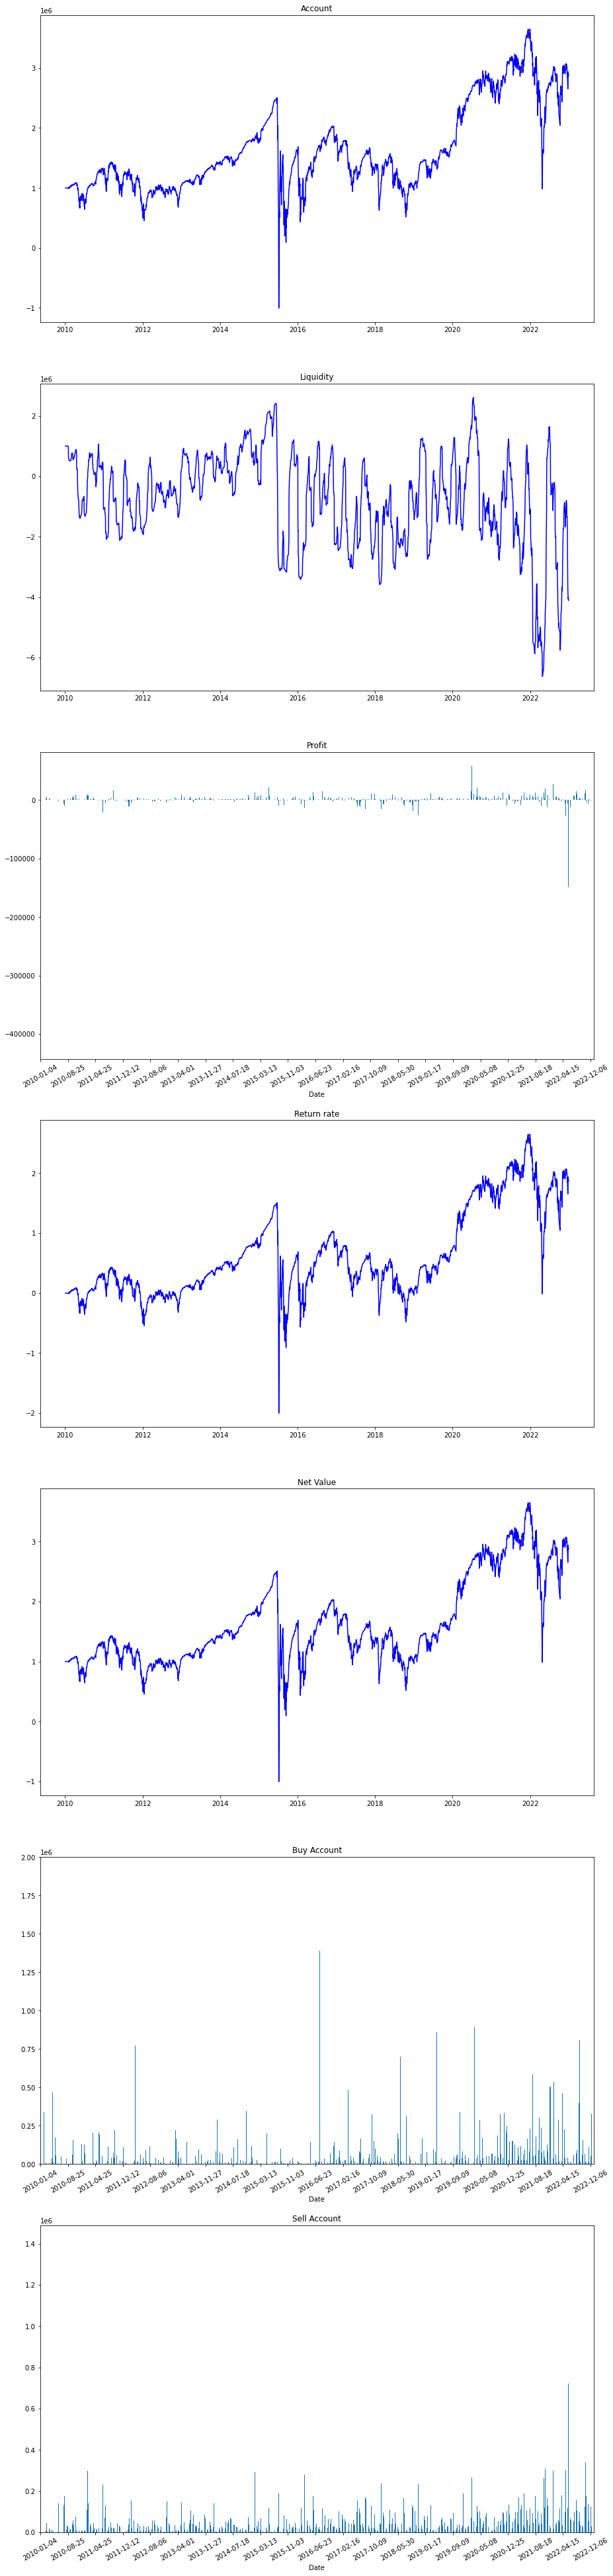

In [17]:
res.TC_Graph()